# setteing

In [1]:
%matplotlib inline 

import gc
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import lightgbm as lgb
import optuna

from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.inspection import partial_dependence
import shap

# dataset

In [2]:
df_transaction_train = pd.read_csv("../input/train_transaction.csv")
df_identity_train = pd.read_csv("../input/train_identity.csv")
df_identity_train["specifyIdentity"] = 1
df_train = pd.merge(df_transaction_train, df_identity_train, how='left', on="TransactionID")
df_train["isTest"] = 0
df_train["specifyIdentity"] = df_train["specifyIdentity"].fillna(0) 
df_train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,specifyIdentity,isTest
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000,590540.000000,590540.0
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597,0.244239,0.0
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502,0.429636,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000,0.000000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000,0.000000,0.0
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000,0.000000,0.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000,0.000000,0.0
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000,1.000000,0.0


In [4]:
df_transaction_test = pd.read_csv("../input/test_transaction.csv")
df_identity_test = pd.read_csv("../input/test_identity.csv")
df_identity_test["specifyIdentity"] = 1
df_test = pd.merge(df_transaction_test, df_identity_test, how='left', on="TransactionID")
df_test["isTest"] = 1
df_test["specifyIdentity"] = df_test["specifyIdentity"].fillna(0)
df_test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,specifyIdentity,isTest
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,...,135906.000000,135633.000000,5059.000000,5062.000000,4740.000000,5039.000000,5047.000000,70671.000000,506691.000000,506691.0
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412,87.065270,...,350.122982,408.886230,507.727021,15.336823,13.166667,332.043064,152.752923,26.217939,0.280066,1.0
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328,314.131694,...,139.140824,158.971756,227.371061,5.618032,3.222440,86.356683,31.916995,3.601046,0.449032,0.0
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,100.000000,100.000000,100.000000,11.000000,10.000000,100.000000,100.000000,8.000000,0.000000,1.0
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.000000,150.000000,166.000000,204.000000,87.000000,3.000000,...,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,137.000000,24.000000,0.000000,1.0
50%,3.916894e+06,2.720466e+07,67.950000,9803.000000,369.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,321.000000,484.000000,576.000000,14.000000,11.000000,321.000000,147.000000,24.000000,0.000000,1.0
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.000000,150.000000,226.000000,330.000000,87.000000,20.000000,...,427.000000,549.000000,711.000000,14.000000,15.000000,355.000000,182.000000,32.000000,1.000000,1.0
max,4.170239e+06,3.421434e+07,10270.000000,18397.000000,600.000000,232.000000,237.000000,540.000000,102.000000,8081.000000,...,670.000000,660.000000,854.000000,44.000000,26.000000,549.000000,216.000000,48.000000,1.000000,1.0


In [5]:
del df_transaction_train
del df_identity_train
del df_transaction_test
del df_identity_test

gc.collect()

85

In [6]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)
df.describe()

C:\Users\999000_113047\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_20,id_21,id_22,id_24,id_25,id_26,id_32,isFraud,isTest,specifyIdentity
count,1.097228e+06,1.097228e+06,1.097228e+06,1.097228e+06,1.092483e+06,1.097228e+06,1.097228e+06,1.097228e+06,1.097228e+06,1.097228e+06,...,274894.000000,10218.000000,10231.000000,9487.000000,10171.000000,10210.000000,148257.000000,590540.000000,1.097231e+06,1.097231e+06
mean,1.224565e+01,3.656317e+00,8.968402e+00,3.417374e+00,3.036952e+01,7.274049e+00,1.316624e+01,1.569227e-02,3.304229e+00,5.290377e+00,...,406.351430,437.316011,15.673248,12.983662,330.814866,150.890695,26.370047,0.034990,4.617906e-01,2.607837e-01
std,1.118594e+02,7.196617e+01,8.079689e+01,7.340473e+01,1.172570e+02,4.114092e+01,1.285684e+02,1.904406e-01,5.800246e+01,2.563929e+01,...,155.578203,224.537299,6.305614,2.834988,92.130618,32.062027,3.675944,0.183755,4.985381e-01,4.390624e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,100.000000,100.000000,10.000000,10.000000,100.000000,100.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,256.000000,252.000000,14.000000,11.000000,321.000000,121.000000,24.000000,0.000000,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,472.000000,277.000000,14.000000,11.000000,321.000000,147.000000,24.000000,0.000000,0.000000e+00,0.000000e+00
75%,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.300000e+01,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,539.000000,711.000000,14.000000,15.000000,360.000000,173.750000,32.000000,0.000000,1.000000e+00,1.000000e+00
max,4.685000e+03,3.257000e+03,3.188000e+03,3.188000e+03,2.918000e+03,1.429000e+03,5.691000e+03,3.100000e+01,2.253000e+03,3.760000e+02,...,661.000000,854.000000,44.000000,26.000000,549.000000,216.000000,48.000000,1.000000,1.000000e+00,1.000000e+00


In [7]:
del df_train
del df_test

gc.collect()

21

# preprocessing

In [8]:
list_categorical_feature = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2", "P_emaildomain", "R_emaildomain", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "DeviceType", "DeviceInfo", "id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", "id_19", "id_20", "id_21", "id_22", "id_23", "id_24", "id_25", "id_26", "id_27", "id_28", "id_29", "id_30", "id_31", "id_32", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]

In [9]:
# df[list_categorical_feature] = df[list_categorical_feature].astype('category')
for col in list_categorical_feature:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

In [10]:
list_col_constant_val = [col for col in df.columns if len(df[col].unique()) == 1]
list_col_constant_val

[]

In [11]:
df = df.drop(columns=list_col_constant_val)

# modeling

In [12]:
params = {
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric':'auc', 
    'seed': 175, 
    'max_depth': 9, 
    'learning_rate': 0.02, 
    'bagging_fraction': 0.8, 
    'feature_fraction': 0.8
}

In [13]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, scoring_metrix, cv, 
                        train_sizes=np.linspace(0.1, 1.0, 10), 
                        title="learning curve", ylim=(0.0, 1.01)):
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
        groups=None, train_sizes=train_sizes, cv=cv, scoring=scoring_metrix, 
        exploit_incremental_learning=False, n_jobs=None, pre_dispatch='all', 
        verbose=0, shuffle=False, random_state=0, error_score='raise-deprecation')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
        train_scores_mean + train_scores_std, alpha=0.1, color='royalblue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
        test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='royalblue', label="training score")
    plt.plot(test_sizes, test_scores_mean, 'o-', color='royalblue', label="cross-validation score")

    plt.set_title(title)
    plt.grid()
    plt.xlabel("training sample")
    plt.ylabel("score")
    plt.ylim(ylim)
    plt.legend(loc='lower right')

    return plt

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y, y_pred_prob, title="ROC curve"):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred_prob, pos_label=1)
    auc_score = auc(false_positive_rate, true_positive_rate)

    plt.plot(false_positive_rate, true_positive_rate, label="ROC curve (area = %.2f)"%auc_score)
    plt.title(title)
    plt.grid()
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend()

    return plt

In [15]:
from sklearn.metrics import precision_recall_curve

def plot_score_changed_thresholds(y, y_pred_prob, title="model-score changed thresholds"):
    precision, recall, thresholds = precision_recall_curve(y, y_pred_prob, pos_label=1)
    thresholds = np.append(thresholds, 1)
    fscore = 2 * precision * recall / (precision + recall)

    plt.plot(thresholds, precision, linestyle='-', color=sns.color_palette('tab10', 4)[0])
    plt.plot(thresholds, recall, linestyle='--', color=sns.color_palette('tab10', 4)[1])
    plt.plot(thresholds, fscore, linestyle='-.', color=sns.color_palette('tab10', 4)[2])

    leg = plt.legend(("precision", "recall", "f-measure"), loc='upper right', frameon=True)
    leg.get_frame().set_edgecolor('k')
    plt.grid()
    plt.xlim([0, 1])
    plt.title("model-score changed thresholds")
    plt.xlim([0, 1])
    plt.xlabel("thresholds")
    plt.ylim([0, 1])
    plt.ylabel("score")

    return plt


## and identify

In [84]:
X_train_and_identify = df.query('isTest == 0 & specifyIdentity == 1').drop(columns=["TransactionDT", "isFraud"])
y_train_and_identify = df.query('isTest == 0 & specifyIdentity == 1')["isFraud"]

X_train_and_identify, X_valid_and_identify, y_train_and_identify, y_valid_and_identify = train_test_split(X_train_and_identify, y_train_and_identify, train_size=0.8, random_state=175, shuffle=True, stratify=y_train_and_identify)
key_train_and_identify = X_train_and_identify["TransactionID"]
X_train_and_identify = X_train_and_identify.drop(columns=["TransactionID"])
key_valid_and_identify = X_valid_and_identify["TransactionID"]
X_valid_and_identify = X_valid_and_identify.drop(columns=["TransactionID"])

X_test_and_identify = df.query('isTest == 1 & specifyIdentity == 1').drop(columns=["TransactionDT", "isFraud"])
key_test_and_identify = X_test_and_identify["TransactionID"]
X_test_and_identify = X_test_and_identify.drop(columns=["TransactionID"])

In [17]:
X_train_and_identify = X_train_and_identify.drop(columns=["isTest"])
X_valid_and_identify = X_valid_and_identify.drop(columns=["isTest"])
X_test_and_identify = X_test_and_identify.drop(columns=["isTest"])

In [18]:
train_data_and_identify = lgb.Dataset(X_train_and_identify, label=y_train_and_identify, categorical_feature=list_categorical_feature, free_raw_data=False)
eval_data_and_identify = lgb.Dataset(X_valid_and_identify, label=y_valid_and_identify, reference= train_data_and_identify, categorical_feature=list_categorical_feature, free_raw_data=False)


In [19]:
gbm_and_identify = lgb.train(
    params,
    train_data_and_identify,
    valid_sets=eval_data_and_identify,
    num_boost_round=1000,
    early_stopping_rounds=100
)

C:\Users\999000_113047\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

C:\Users\999000_113047\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's auc: 0.872335
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.894352
[3]	valid_0's auc: 0.911348
[4]	valid_0's auc: 0.911706
[5]	valid_0's auc: 0.914931
[6]	valid_0's auc: 0.91724
[7]	valid_0's auc: 0.919453
[8]	valid_0's auc: 0.923064
[9]	valid_0's auc: 0.923487
[10]	valid_0's auc: 0.923467
[11]	valid_0's auc: 0.923592
[12]	valid_0's auc: 0.925335
[13]	valid_0's auc: 0.925725
[14]	valid_0's auc: 0.925998
[15]	valid_0's auc: 0.926715
[16]	valid_0's auc: 0.926778
[17]	valid_0's auc: 0.927776
[18]	valid_0's auc: 0.928313
[19]	valid_0's auc: 0.928537
[20]	valid_0's auc: 0.929206
[21]	valid_0's auc: 0.929301
[22]	valid_0's auc: 0.929765
[23]	valid_0's auc: 0.932203
[24]	valid_0's auc: 0.932382
[25]	valid_0's auc: 0.932779
[26]	valid_0's auc: 0.932985
[27]	valid_0's auc: 0.93308
[28]	valid_0's auc: 0.933553
[29]	valid_0's auc: 0.933825
[30]	valid_0's auc: 0.93414
[31]	valid_0's auc: 0.934452
[32]	valid_0's auc: 0.934403
[33]	valid_0's auc: 0

[550]	valid_0's auc: 0.975648
[551]	valid_0's auc: 0.975683
[552]	valid_0's auc: 0.975703
[553]	valid_0's auc: 0.975712
[554]	valid_0's auc: 0.975731
[555]	valid_0's auc: 0.975751
[556]	valid_0's auc: 0.975752
[557]	valid_0's auc: 0.975768
[558]	valid_0's auc: 0.975762
[559]	valid_0's auc: 0.975781
[560]	valid_0's auc: 0.975789
[561]	valid_0's auc: 0.975806
[562]	valid_0's auc: 0.975812
[563]	valid_0's auc: 0.97581
[564]	valid_0's auc: 0.97582
[565]	valid_0's auc: 0.975845
[566]	valid_0's auc: 0.975842
[567]	valid_0's auc: 0.975854
[568]	valid_0's auc: 0.975873
[569]	valid_0's auc: 0.975875
[570]	valid_0's auc: 0.975898
[571]	valid_0's auc: 0.975896
[572]	valid_0's auc: 0.975892
[573]	valid_0's auc: 0.975902
[574]	valid_0's auc: 0.975909
[575]	valid_0's auc: 0.975922
[576]	valid_0's auc: 0.975937
[577]	valid_0's auc: 0.975967
[578]	valid_0's auc: 0.975974
[579]	valid_0's auc: 0.975986
[580]	valid_0's auc: 0.975988
[581]	valid_0's auc: 0.975992
[582]	valid_0's auc: 0.97601
[583]	valid_0

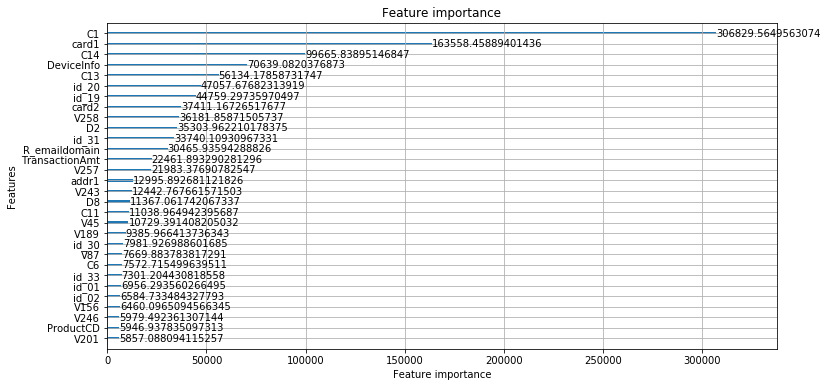

In [20]:
lgb.plot_importance(gbm_and_identify, importance_type='gain', max_num_features=30, figsize=(12, 6))

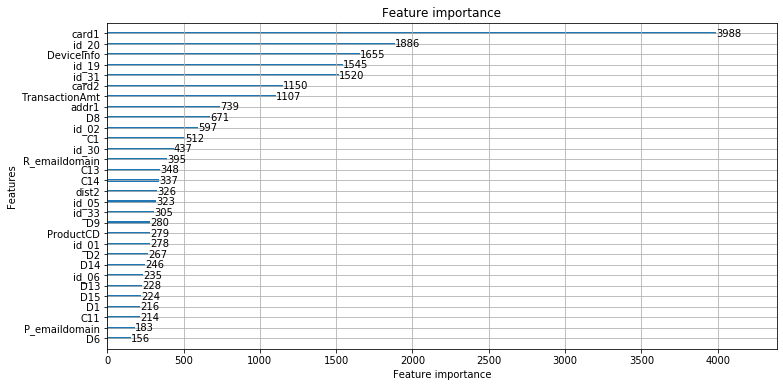

In [21]:
lgb.plot_importance(gbm_and_identify, importance_type='split', max_num_features=30, figsize=(12, 6))

In [22]:
y_pred_prob_and_identify = gbm_and_identify.predict(X_valid_and_identify)
y_pred_prob_and_identify

array([3.36743282e-04, 2.42079804e-04, 2.78157637e-02, ...,
       5.43224212e-04, 4.12744721e-04, 5.03274775e-05])

In [23]:
df_valid_and_identify = X_valid_and_identify.copy()
df_valid_and_identify["isFraud"] = y_valid_and_identify
df_valid_and_identify["predict_prob"] = y_pred_prob_and_identify

(0, 1)

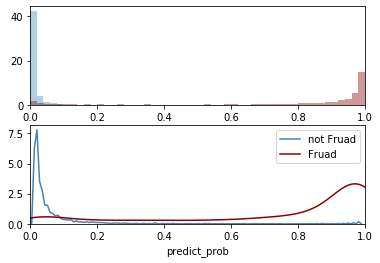

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
sns.distplot(df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==0, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=True, color="steelblue", label="not Fruad", ax=ax1)
sns.distplot(df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==1, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=True, color="darkred", label="Fruad", ax=ax1)

ax2 = fig.add_subplot(212, sharex=ax1)
sns.distplot(df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==0, "predict_prob"], bins=50, hist=False, kde=True, norm_hist=False, color="steelblue", label="not Fruad", ax=ax2)
sns.distplot(df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==1, "predict_prob"], bins=50, hist=False, kde=True, norm_hist=False, color="darkred", label="Fruad", ax=ax2)

plt.xlim([0, 1])

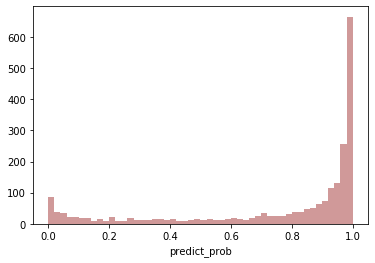

In [25]:
sns.distplot(df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==1, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=False, color="darkred", label="Fruad")

In [26]:
df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==1, ].sort_values("predict_prob").head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,specifyIdentity,isFraud,predict_prob
88988,2.0,3.0,2.0,0.0,3.0,2.0,2.0,0.0,2.0,0.0,...,3,220,3,1,0,1,1,1.0,1.0,0.000297
386105,1.0,1.0,1.0,0.0,3.0,1.0,2.0,0.0,3.0,0.0,...,3,216,3,1,0,1,1,1.0,1.0,0.000315
41571,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,4,80,2,1,0,0,1,1.0,1.0,0.000520
58284,2.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,...,3,216,3,1,0,1,0,1.0,1.0,0.000821
71412,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,4,62,3,1,0,1,1,1.0,1.0,0.000888


In [27]:
df_valid_and_identify.loc[df_valid_and_identify["isFraud"]==1, ].sort_values("predict_prob").tail()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,specifyIdentity,isFraud,predict_prob
278070,7.0,1.0,8.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,...,3,98,2,1,0,1,0,1.0,1.0,0.999610
379664,9.0,1.0,4.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,...,4,267,2,1,0,1,0,1.0,1.0,0.999616
278068,7.0,1.0,8.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,...,3,98,2,1,0,1,0,1.0,1.0,0.999630
172865,4.0,1.0,5.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,...,4,449,3,1,0,1,0,1.0,1.0,0.999697
590004,5.0,1.0,5.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,3,68,3,1,0,0,0,1.0,1.0,0.999801


In [28]:
df_valid_and_identify["input_rate"] = 1 - df_valid_and_identify.isna().sum(axis=1) / len(df_valid_and_identify.columns)
df_valid_and_identify["input_rate"].describe()

count    28847.000000
mean         0.778023
std          0.072023
min          0.398618
25%          0.735023
50%          0.748848
75%          0.838710
max          0.963134
Name: input_rate, dtype: float64

In [29]:
# sns.lmplot(x="predict_prob", y="input_rate", data=df_valid_and_identify.query('isFraud == 1'))

In [30]:
# sns.relplot(x="predict_prob", y="input_rate", col="isFraud", data=df_valid_and_identify)

In [31]:
# grid = sns.FacetGrid(df_valid_and_identify, col="specifyIdentity", row="isFraud")
# grid.map(sns.distplot, "predict_prob", hist=False, kde=True)

In [32]:
# plot_learning_curve(gbm, X_valid, y_valid, scoring_metrix='roc_auc', cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0))

<module 'matplotlib.pyplot' from 'C:\\Users\\999000_113047\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

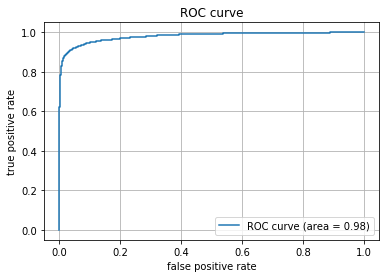

In [33]:
plot_roc_curve(y_valid_and_identify, y_pred_prob_and_identify)

<module 'matplotlib.pyplot' from 'C:\\Users\\999000_113047\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

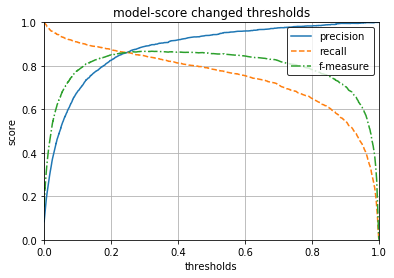

In [34]:
plot_score_changed_thresholds(y_valid_and_identify, y_pred_prob_and_identify)

## no identify

In [85]:
X_train_no_identify = df.query('isTest == 0 & specifyIdentity == 0').drop(columns=["TransactionDT", "isFraud"])
y_train_no_identify = df.query('isTest == 0 & specifyIdentity == 0')["isFraud"]

X_train_no_identify, X_valid_no_identify, y_train_no_identify, y_valid_no_identify = train_test_split(X_train_no_identify, y_train_no_identify, train_size=0.8, random_state=175, shuffle=True, stratify=y_train_no_identify)
key_train_no_identify = X_train_no_identify["TransactionID"]
X_train_no_identify = X_train_no_identify.drop(columns=["TransactionID"])
key_valid_no_identify = X_valid_no_identify["TransactionID"]
X_valid_no_identify = X_valid_no_identify.drop(columns=["TransactionID"])

X_test_no_identify = df.query('isTest == 1 & specifyIdentity == 0').drop(columns=["TransactionDT", "isFraud"])
key_test_no_identify = X_test_no_identify["TransactionID"]
X_test_no_identify = X_test_no_identify.drop(columns=["TransactionID"])

In [36]:
X_train_no_identify = X_train_no_identify.drop(columns=["isTest"])
X_valid_no_identify = X_valid_no_identify.drop(columns=["isTest"])
X_test_no_identify = X_test_no_identify.drop(columns=["isTest"])

In [37]:
train_data_no_identify = lgb.Dataset(X_train_no_identify, label=y_train_no_identify, categorical_feature=list_categorical_feature, free_raw_data=False)
eval_data_no_identify = lgb.Dataset(X_valid_no_identify, label=y_valid_no_identify, reference= train_data_no_identify, categorical_feature=list_categorical_feature, free_raw_data=False)


In [38]:
gbm_no_identify = lgb.train(
    params,
    train_data_no_identify,
    valid_sets=eval_data_no_identify,
    num_boost_round=1000,
    early_stopping_rounds=100
)

C:\Users\999000_113047\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

C:\Users\999000_113047\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's auc: 0.742728
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.806799
[3]	valid_0's auc: 0.810824
[4]	valid_0's auc: 0.814233
[5]	valid_0's auc: 0.815362
[6]	valid_0's auc: 0.817572
[7]	valid_0's auc: 0.821885
[8]	valid_0's auc: 0.822853
[9]	valid_0's auc: 0.823007
[10]	valid_0's auc: 0.823393
[11]	valid_0's auc: 0.823788
[12]	valid_0's auc: 0.82957
[13]	valid_0's auc: 0.830006
[14]	valid_0's auc: 0.834653
[15]	valid_0's auc: 0.838461
[16]	valid_0's auc: 0.840185
[17]	valid_0's auc: 0.84096
[18]	valid_0's auc: 0.842674
[19]	valid_0's auc: 0.843664
[20]	valid_0's auc: 0.844029
[21]	valid_0's auc: 0.844892
[22]	valid_0's auc: 0.846392
[23]	valid_0's auc: 0.84725
[24]	valid_0's auc: 0.847658
[25]	valid_0's auc: 0.847572
[26]	valid_0's auc: 0.847655
[27]	valid_0's auc: 0.849178
[28]	valid_0's auc: 0.850716
[29]	valid_0's auc: 0.85152
[30]	valid_0's auc: 0.853207
[31]	valid_0's auc: 0.858
[32]	valid_0's auc: 0.859179
[33]	valid_0's auc: 0.859

[277]	valid_0's auc: 0.930206
[278]	valid_0's auc: 0.930287
[279]	valid_0's auc: 0.930395
[280]	valid_0's auc: 0.930453
[281]	valid_0's auc: 0.930582
[282]	valid_0's auc: 0.930704
[283]	valid_0's auc: 0.93079
[284]	valid_0's auc: 0.930864
[285]	valid_0's auc: 0.930961
[286]	valid_0's auc: 0.931095
[287]	valid_0's auc: 0.931176
[288]	valid_0's auc: 0.931262
[289]	valid_0's auc: 0.931351
[290]	valid_0's auc: 0.93141
[291]	valid_0's auc: 0.931493
[292]	valid_0's auc: 0.931591
[293]	valid_0's auc: 0.931629
[294]	valid_0's auc: 0.9317
[295]	valid_0's auc: 0.931792
[296]	valid_0's auc: 0.931851
[297]	valid_0's auc: 0.931959
[298]	valid_0's auc: 0.932095
[299]	valid_0's auc: 0.932177
[300]	valid_0's auc: 0.932263
[301]	valid_0's auc: 0.932399
[302]	valid_0's auc: 0.93248
[303]	valid_0's auc: 0.932592
[304]	valid_0's auc: 0.932687
[305]	valid_0's auc: 0.932758
[306]	valid_0's auc: 0.932843
[307]	valid_0's auc: 0.932936
[308]	valid_0's auc: 0.933016
[309]	valid_0's auc: 0.933103
[310]	valid_0's

[824]	valid_0's auc: 0.951372
[825]	valid_0's auc: 0.95142
[826]	valid_0's auc: 0.951436
[827]	valid_0's auc: 0.951438
[828]	valid_0's auc: 0.951468
[829]	valid_0's auc: 0.951488
[830]	valid_0's auc: 0.951482
[831]	valid_0's auc: 0.951502
[832]	valid_0's auc: 0.951518
[833]	valid_0's auc: 0.951542
[834]	valid_0's auc: 0.951549
[835]	valid_0's auc: 0.951552
[836]	valid_0's auc: 0.951547
[837]	valid_0's auc: 0.95157
[838]	valid_0's auc: 0.951588
[839]	valid_0's auc: 0.951597
[840]	valid_0's auc: 0.951617
[841]	valid_0's auc: 0.951624
[842]	valid_0's auc: 0.951624
[843]	valid_0's auc: 0.951636
[844]	valid_0's auc: 0.951675
[845]	valid_0's auc: 0.951676
[846]	valid_0's auc: 0.951689
[847]	valid_0's auc: 0.951709
[848]	valid_0's auc: 0.951723
[849]	valid_0's auc: 0.951741
[850]	valid_0's auc: 0.951745
[851]	valid_0's auc: 0.951756
[852]	valid_0's auc: 0.951776
[853]	valid_0's auc: 0.951786
[854]	valid_0's auc: 0.951807
[855]	valid_0's auc: 0.951808
[856]	valid_0's auc: 0.951826
[857]	valid_

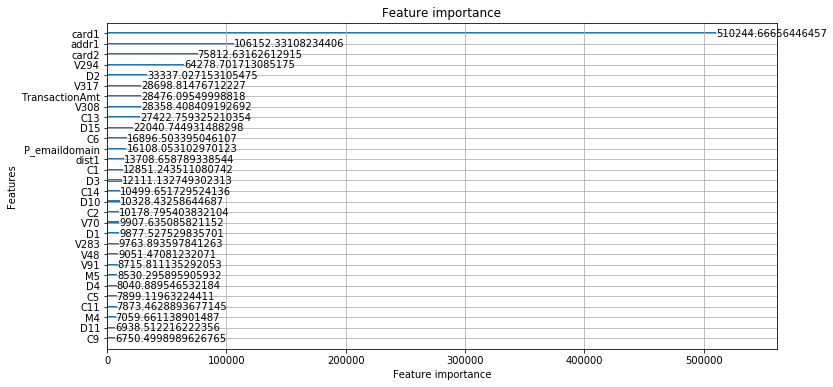

In [39]:
lgb.plot_importance(gbm_no_identify, importance_type='gain', max_num_features=30, figsize=(12, 6))

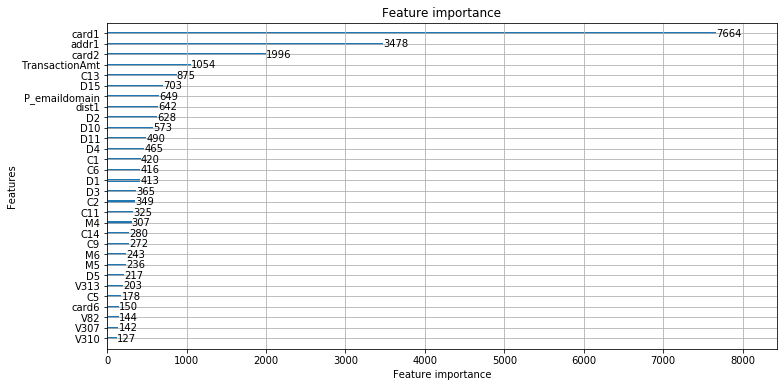

In [40]:
lgb.plot_importance(gbm_no_identify, importance_type='split', max_num_features=30, figsize=(12, 6))

In [41]:
y_pred_prob_no_identify = gbm_no_identify.predict(X_valid_no_identify)
y_pred_prob_no_identify

array([0.00028246, 0.01858706, 0.00051384, ..., 0.00289925, 0.00146149,
       0.01369576])

In [42]:
df_valid_no_identify = X_valid_no_identify.copy()
df_valid_no_identify["isFraud"] = y_valid_no_identify
df_valid_no_identify["predict_prob"] = y_pred_prob_no_identify

(0, 1)

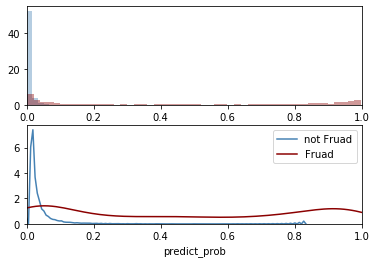

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
sns.distplot(df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==0, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=True, color="steelblue", label="not Fruad", ax=ax1)
sns.distplot(df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==1, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=True, color="darkred", label="Fruad", ax=ax1)

ax2 = fig.add_subplot(212, sharex=ax1)
sns.distplot(df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==0, "predict_prob"], bins=50, hist=False, kde=True, norm_hist=False, color="steelblue", label="not Fruad", ax=ax2)
sns.distplot(df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==1, "predict_prob"], bins=50, hist=False, kde=True, norm_hist=False, color="darkred", label="Fruad", ax=ax2)

plt.xlim([0, 1])

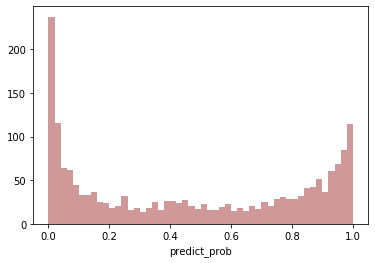

In [44]:
sns.distplot(df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==1, "predict_prob"], bins=50, hist=True, kde=False, norm_hist=False, color="darkred", label="Fruad")

In [45]:
df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==1, ].sort_values("predict_prob").head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,specifyIdentity,isFraud,predict_prob
95563,1.0,0.0,1.0,0.0,11.0,1.0,1.0,0.0,0.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.000196
518495,2.0,0.0,1.0,0.0,4.0,2.0,3.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.000399
111934,2.0,0.0,2.0,0.0,35.0,2.0,2.0,0.0,0.0,2.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.000410
453010,2.0,0.0,1.0,0.0,7.0,2.0,1.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.000615
275122,4.0,0.0,4.0,0.0,4.0,4.0,4.0,0.0,0.0,1.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.000705


In [46]:
df_valid_no_identify.loc[df_valid_no_identify["isFraud"]==1, ].sort_values("predict_prob").tail()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,specifyIdentity,isFraud,predict_prob
225464,5.0,0.0,1.0,0.0,56.0,3.0,2.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.996337
240454,5.0,0.0,1.0,0.0,56.0,3.0,2.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.997320
301225,2.0,0.0,3.0,2.0,7.0,2.0,4.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.998351
301096,2.0,0.0,3.0,2.0,7.0,2.0,4.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.998428
301090,2.0,0.0,3.0,2.0,6.0,2.0,3.0,0.0,0.0,0.0,...,-1,-1,-1,-1,-1,-1,-1,0.0,1.0,0.998585


In [47]:
df_valid_no_identify["input_rate"] = 1 - df_valid_no_identify.isna().sum(axis=1) / len(df_valid_no_identify.columns)
df_valid_no_identify["input_rate"].describe()

count    89262.000000
mean         0.567398
std          0.028320
min          0.334101
25%          0.552995
50%          0.580645
75%          0.589862
max          0.769585
Name: input_rate, dtype: float64

In [48]:
# sns.lmplot(x="predict_prob", y="input_rate", data=df_valid_no_identify.query('isFraud == 1'))

In [49]:
# sns.relplot(x="predict_prob", y="input_rate", col="isFraud", data=df_valid_no_identify)

In [50]:
# grid = sns.FacetGrid(df_valid_no_identify, col="specifyIdentity", row="isFraud")
# grid.map(sns.distplot, "predict_prob", hist=False, kde=True)

In [51]:
# plot_learning_curve(gbm, X_valid, y_valid, scoring_metrix='roc_auc', cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0))

<module 'matplotlib.pyplot' from 'C:\\Users\\999000_113047\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

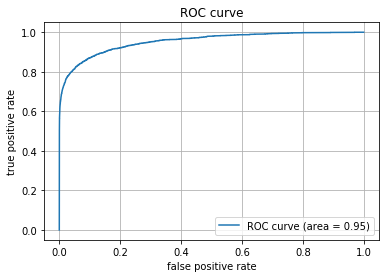

In [52]:
plot_roc_curve(y_valid_no_identify, y_pred_prob_no_identify)

<module 'matplotlib.pyplot' from 'C:\\Users\\999000_113047\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

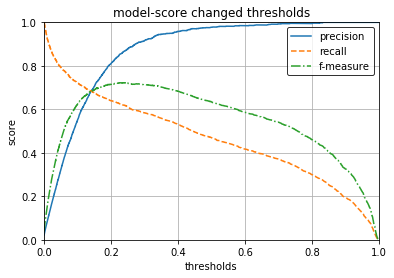

In [53]:
plot_score_changed_thresholds(y_valid_no_identify, y_pred_prob_no_identify)

In [86]:
df_predict = pd.DataFrame([])
df_predict["TransactionID"] = np.hstack((key_test_and_identify, key_test_no_identify))
df_predict["isFraud"] = np.hstack((gbm_and_identify.predict(X_test_and_identify), gbm_no_identify.predict(X_test_no_identify)))
df_predict.shape

(506691, 2)

In [87]:
sub = pd.DataFrame(pd.read_csv("../input/test_transaction.csv")['TransactionID'])
sub = pd.merge(sub, df_predict, on="TransactionID")
sub.to_csv("submission.csv", index = False)
# df_predict.to_csv("submission.csv", index = False)
sub.shape

NameError: name 'subub' is not defined

In [ ]:
def write_spreadsheet(*args):
    endpoint = 'https://script.google.com/macros/s/AKfycbxZhZc3lPJ6eLATt_r9dPVQZUjuzpIvQ6vjSYFZdLOlt1TqWvtC/exec'
    requests.post(endpoint, json.dumps(args))

In [ ]:
# write_spreadsheet('baseline', *scores)
write_spreadsheet('baseline', auc)

# explain

In [ ]:
# explainer = shap.TreeExplainer(gbm)
# shap_values = explainer.shap_values(X_valid)

In [ ]:
# df_shap = pd.DataFrame(data=shap_values, index=key_valid, columns=X_valid.columns)
# df_shap.to_csv("shap_value.csv", index = False)

In [ ]:
# shap.initjs()

In [ ]:
# shap.summary_plot(shap_values, X_valid)

In [ ]:
# sns.relplot(x="predict_prob", y="card1", col="isFraud", data=df_valid)

In [ ]:
# sns.relplot(x="predict_prob", y="TransactionAmt", col="isFraud", data=df_valid)

In [ ]:
# shap.dependence_plot("card1", shap_values, X_valid)

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:])

In [ ]:
# index_key = df_valid["predict_prob"].reset_index(drop=True).idxmax()
# shap.force_plot(explainer.expected_value, shap_values[index_key,:], X_valid.iloc[index_key,:])

In [ ]:
# index_key = df_valid["predict_prob"].reset_index(drop=True).idxmin()
# shap.force_plot(explainer.expected_value, shap_values[index_key,:], X_valid.iloc[index_key,:])

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[1:1000], X_valid[1:1000])

In [ ]:
# shap_interaction_values = explainer.shap_interaction_values(train_X)

In [ ]:
# shap.summary_plot(shap_interaction_values, train_X)

In [ ]:
def send_line_notification(message):
    line_token = 'tB3RUUxiXOOMB8KjRJXsBEWP2zAnaWzRypXKmQHsiNd'  # 終わったら無効化する
    endpoint = 'https://notify-api.line.me/api/notify'
    message = "\n{}".format(message)
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

In [ ]:
send_line_notification("execution compelete!")